In [ ]:
!pip install imgaug
!pip install tensorflow-gpu
!pip install mtcnn

In [3]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import imgaug as ia
from imgaug import augmenters as iaa
import torch
import matplotlib.pyplot as plt
from skimage import io
from mtcnn import MTCNN
from tensorflow.image import crop_to_bounding_box

In [ ]:
from google.cloud import storage

# Connect to google cloud storage
client = storage.Client()

bucket_name = "tdt4173-datasets"
bucket = client.get_bucket(bucket_name)

# Download videos from google cloud storage
DATASET = "faces/videos/faces_final.zip"
FILEPATH = "/home/jupyter/data/faces/faces_final.zip"
blob = bucket.get_blob(DATASET)
blob.download_to_filename(FILEPATH)
!mkdir -p /home/jupyter/data/faces/videos/
!unzip /home/jupyter/data/faces/faces_final.zip -d /home/jupyter/data/faces/videos/

In [14]:
detector = MTCNN()

In [23]:
from tensorflow.image import crop_to_bounding_box
def crop_by_bounding_box(img, detector, vertical_expand=0.05, draw=False):
    result = detector.detect_faces(img)
    if len(result) == 0:
        return None
    bounding_box = result[0]['box']
    
    if draw:
        before = img.copy()
        cv2.rectangle(img,
                  (bounding_box[0], bounding_box[1]),
                  (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
                  (255,255,255),
                  10)

    y = bounding_box[1]
    x = bounding_box[0]
    height = bounding_box[3]
    width = bounding_box[2]

    # Account for top left corner outside image
    if y < 0:
        height += y
        y = 0
    if x < 0:
        width += x
        x = 0

    # Expand bounding box vertically by vertical_expand % in each direction
    # Move y-coord of top-left corner upwards
    old_y = y
    y = max(y - int(vertical_expand * height), 0)
    height += (old_y - y)

    # Increase height of bounding box
    h, w, _ = img.shape
    height = min(int((1 + vertical_expand) * height), h)

    # Fill horizontally or vertically until width = height
    if height > width:
        if height > w:
            x = 0
            width = w
        else:
            diff_to_fill = height - width

            # Fill leftwards
            old_x = x
            x = max(0, x - int(diff_to_fill / 2))
            x_change = (old_x - x)
            diff_to_fill -= x_change
            width += x_change

            # Fill rightwards
            width = min(width + diff_to_fill, w - x)
    else:
        diff_to_fill = width - height
        # Fill upwards
        old_y = y
        y = max(0, y - int(diff_to_fill/2))
        y_change = (old_y - y)
        diff_to_fill -= y_change
        height += y_change

        # Fill downwards
        height += min(height + diff_to_fill, h - y)
    # Cut height if larger than width
    if height > w:
        diff = height - w
        y += int(diff/2)
        height -= diff

    crop = crop_to_bounding_box(img, y, x, height, width).numpy()

    if draw: 
        images = [before, img, crop]
        plt.imshow(ia.draw_grid(images, cols=len(images), rows=1))
    return crop

(224, 224, 3)


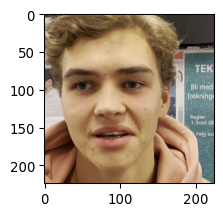

In [25]:
# Read input image

image = cv2.imread("/home/jupyter/data/faces/images/raw/Lars/lars_video_1_36.jpg", cv2.IMREAD_COLOR)
#ia.imshow(image)

# Crop to square
#crop = iaa.CropToFixedSize(height=min([h, w]), width=min([h,w]), position='center')
#cropped = crop(image=image)
cropped = crop_by_bounding_box(image, detector, vertical_expand=0.1, draw=False)

#ia.imshow(cropped)

# Downsize
img_size = 224
resized = cv2.resize(cropped, (img_size, img_size))
print(resized.shape)

ia.imshow(resized)

images = [image, cropped, resized]
#ia.imshow(ia.draw_grid(images, cols=len(images), rows=1))


Augmented:


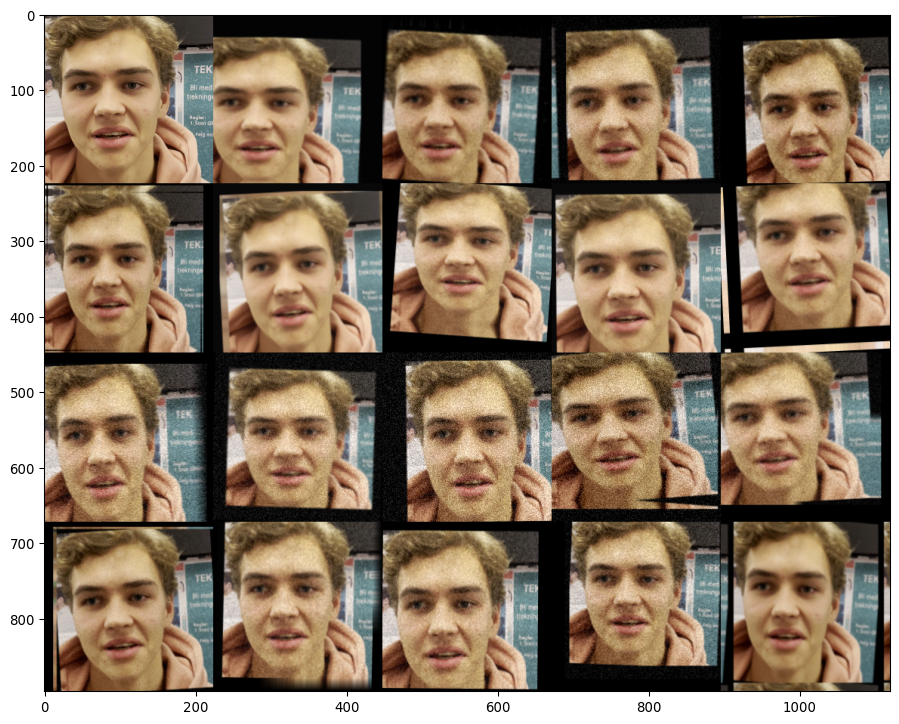

In [37]:
image = resized


seq = iaa.Sequential([
    iaa.Affine(rotate=(-5, 5)),
    iaa.CropAndPad(percent=(-0.05, 0.1), pad_mode=ia.ALL, pad_cval=(0, 0)), # crop images by -5% to 10% of their height/width
    iaa.AdditiveGaussianNoise(scale=(0, 20)), 
    iaa.GaussianBlur(sigma=(0, 1.0)), # Blur images using a gaussian kernel with sigma between 0.0 and 1.0.
    iaa.Add((-10,10)), # change brightness of images (by -10 to 10 of original value)
    iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, cval=(0,0)) # translate by -10 to +10 percent (per axis)
], random_order=True)


images_aug = [seq(image=image) for _ in range(19)] # random order is sampled once per batch, and not once per image in the batch
rows=4
print("Augmented:")
images_aug.insert(0, image)

ia.imshow(ia.draw_grid(images_aug, cols=len(images_aug)/rows, rows=rows))


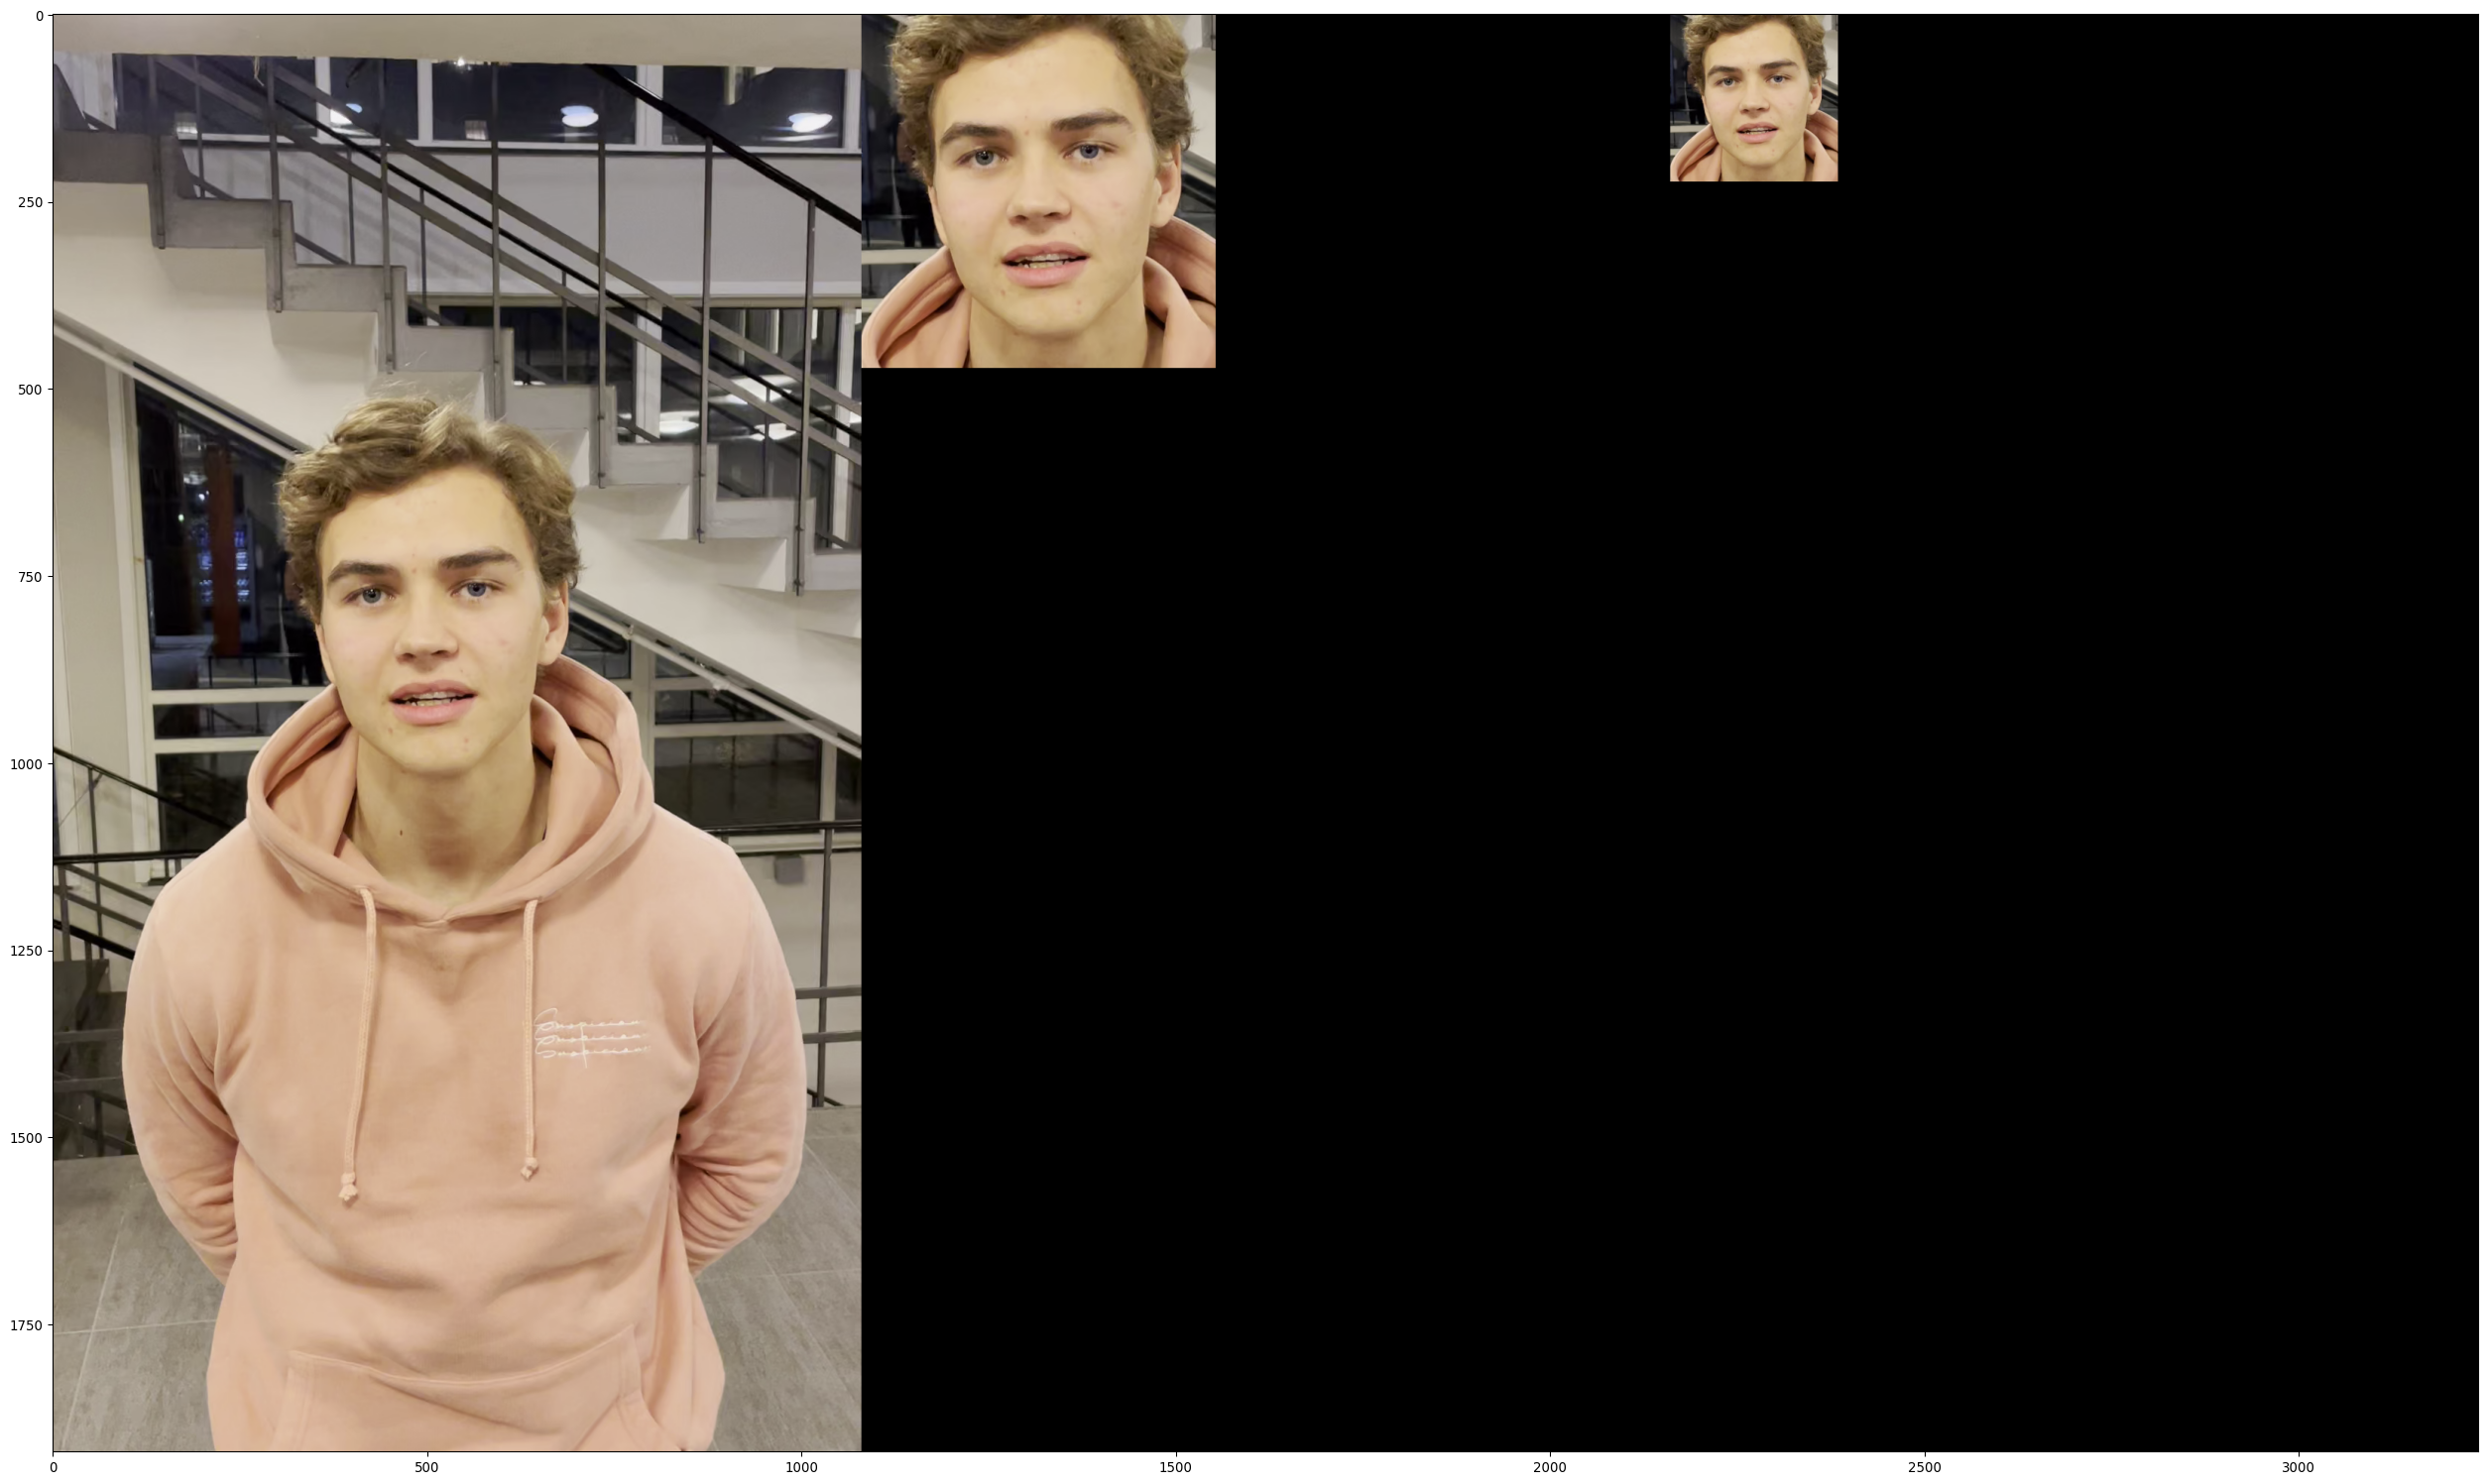

In [40]:
# Read input image
vidcap = cv2.VideoCapture("/home/jupyter/data/faces/videos/Lars/IMG_0011.MOV")
success, image = vidcap.read()



# Convert to BGR to RGB
converted = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h,w, _ = converted.shape # 1080x1920 (rotated 90deg left)

# Rotate
rotated = np.array(np.rot90(converted, k=3))


# Crop to square
#crop = iaa.CropToFixedSize(height=min([h, w]), width=min([h,w]), position='center')
#cropped = crop(image=image)
cropped = crop_by_bounding_box(rotated, detector, vertical_expand=0.1, draw=False)

#ia.imshow(cropped)

# Downsize
img_size = 224
resized = cv2.resize(cropped, (img_size, img_size))

#ia.imshow(resized)

images = [rotated, cropped, resized]
ia.imshow(ia.draw_grid(images, cols=len(images), rows=1))
